In [1]:
import os
import sys
import os
import glob
import random
import time
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset

import torchvision.models as models
from torchvision.models import VGG16_Weights

import torchvision.transforms.functional as F

from torchvision.transforms.functional import to_tensor, resize, center_crop, rotate, adjust_brightness

## Constants

In [2]:
DATA_PATH = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"

plt.style.use("dark_background")

IMG_SIZE = 512
MASK_SIZE = 128

EPOCHS = 150
PATIENCE = 5
BATCH_SIZE = 8

LABELS = ['Positive', 'Negative']
colors = ['olive' , 'lightblue']

## Utility Functions

In [3]:
def get_sample_df(df, type, expected, count, column=None):
    sample_df = df[df[type] == expected].sample(count)
    if column: return sample_df[column]
    return sample_df
    
def split(df, test_size):
    df1, df2 = train_test_split(df, stratify=df.diagnosis, test_size=test_size)
    return df1.reset_index(drop=True), df2.reset_index(drop=True) 

def print_data_shapes(train_df, val_df, test_df):
    print(f"{'Dataset':<10} {'Shape':<15}")
    print(f"{'-'*25}")
    print(f"{'Train':<10} {train_df.shape}")
    print(f"{'Validation':<10} {val_df.shape}")
    print(f"{'Test':<10} {test_df.shape}")

In [4]:
def upsample_dataset(initial_df):
    pos_counts = initial_df['diagnosis'].value_counts() 
    max_count = pos_counts.max()

    dfs = []
    for label, count in pos_counts.items():
        subset_df = initial_df[initial_df['diagnosis'] == label]
        if count < max_count:
            repeat_count = max_count - count
            repeated_subset_df = subset_df.sample(repeat_count, replace=True)
            dfs.append(repeated_subset_df)
    
    initial_df = pd.concat([initial_df] + dfs, ignore_index=True).sample(frac=1).reset_index(drop=True)
    return initial_df

def read_data_pathes(path):
    data_map = []
    for sub_dir_path in glob.glob(path+"*"):
        if not os.path.isdir(sub_dir_path):
            continue
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
        
    df = pd.DataFrame({'dirname' : data_map[::2], 'path' : data_map[1::2]})
    return df

def separate_and_sort_paths(df, base_len=89, end_img_len=4, end_mask_len=9):
    df_imgs = df[~df['path'].str.contains("mask")]
    df_masks = df[df['path'].str.contains("mask")]

    imgs = sorted(df_imgs["path"].values, key=lambda x: int(x[base_len:-end_img_len]))
    masks = sorted(df_masks["path"].values, key=lambda x: int(x[base_len:-end_mask_len]))
    df = pd.DataFrame({'patient': df_imgs.dirname.values, 'image_path': imgs, 'mask_path': masks})

    return imgs, masks, df

def prepare_sample_images(sample_pos_df, sample_neg_df, row_count=3):
    sample_pos_df = sample_pos_df['image_path'].values
    sample_neg_df = sample_neg_df['image_path'].values

    sample_imgs = []
    for neg, pos in zip(sample_neg_df, sample_pos_df):
        neg_img = cv2.resize(cv2.imread(neg), (IMG_SIZE, IMG_SIZE))
        pos_img = cv2.resize(cv2.imread(pos), (IMG_SIZE, IMG_SIZE))
        sample_imgs.extend([pos_img, neg_img])

    sample_pos_arr = np.vstack(sample_imgs[::2])
    sample_neg_arr = np.vstack(sample_imgs[1::2])

    return sample_pos_arr, sample_neg_arr

## Plot Functions

In [36]:
from skimage.transform import resize

class PlotUtils:
    @staticmethod
    def _add_annotations(ax, values, offset=12, fontsize=15, fontweight='bold'):
        for i, value in enumerate(values):
            ax.annotate(
                int(value), xy=(i, value - offset), rotation=0, color='white', ha='center', 
                verticalalignment='bottom', fontsize=fontsize, fontweight=fontweight
            )
    
    @staticmethod
    def plot_histogram(df, ylabel='Image Count', title='Dataset Histogram', fontsize=12):
        ax = df.diagnosis.value_counts().plot(
            kind='bar', stacked=True, figsize=(10, 6), color=colors
        )
        PlotUtils._add_annotations(ax, df.diagnosis.value_counts().values)
        bounding_box = dict(boxstyle='round', fc='lightblue', ec='black')
        ax.text(
            1.2, 2550, f"Total {len(df)} images", size=fontsize+3, 
            color='black', ha='center', va='center', bbox=bounding_box,
        )
        ax.set_xticklabels(LABELS, rotation=45, fontsize=fontsize)
        ax.set_ylabel(ylabel, fontsize=fontsize)
        ax.set_title(title, fontsize=fontsize+6, y=1.05)
    
    @staticmethod
    def plot_distribution(df, ylabel='Total Images', title='Dataset Distribution'):
        patients_by_diagnosis = (
            df.groupby(['patient', 'diagnosis'])['diagnosis']
            .size().unstack().fillna(0)
        )
        patients_by_diagnosis.columns = ["Positive", "Negative"]
        ax = patients_by_diagnosis.plot(
            kind='bar', stacked=True, figsize=(18, 10), color=colors, alpha=0.9
        )
        ax.legend(fontsize=20)
        ax.set_xlabel('Patients', fontsize=20)
        ax.set_ylabel(ylabel, fontsize=20)
        ax.set_title(title, fontsize=25, y=1.005)
        ax.set_xticklabels([])

    @staticmethod
    def general_plot(image_set, titles, cmaps, nrows, ncols, y=0, hstack=False, fontsize=15):
        fig = plt.figure(figsize=(10, 10))
        grid = ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), axes_pad=0.1)

        for i, (data, title) in enumerate(zip(image_set, titles)):
            data = np.hstack(data) if hstack else data
            grid[i].imshow(data, cmap=cmaps[i])
            grid[i].set_title(title, fontsize=fontsize, y=y)
            grid[i].axis('off')

        plt.style.use("dark_background")
        plt.show()
            
    @staticmethod
    def plot_augmented_images(data, mask=False):
        ncols = len(data)
        plt.figure(figsize=(ncols * (IMG_SIZE / 100), IMG_SIZE / 100))
        plt.subplots_adjust(wspace=0, hspace=0)
        
        for idx, img in enumerate(data):
            if mask: img = img.numpy().astype(np.float32)[0, :, :]
            else:    img = img.numpy().transpose(1, 2, 0)

            plt.subplot(1, ncols, idx + 1)
            plt.imshow(img)
            plt.axis('off')

        plt.style.use("dark_background")
        plt.show()


    @staticmethod            
    def _plot_sample(plot_data, title_fontsize=14, alpha=0.5):
        fig, axes = plt.subplots(1, 4, figsize=(18, 6))
        for i, (img, title, cmap) in enumerate(plot_data):
            axes[i].imshow(img, cmap=cmap)
            axes[i].set_title(title, fontsize=title_fontsize)
            axes[i].axis('off')

        axes[3].imshow(plot_data[-2][0], cmap='Blues', alpha=alpha)
        axes[3].imshow(plot_data[-1][0], cmap='Reds', alpha=alpha)
        axes[3].set_title('Detection Heatmap', fontsize=title_fontsize)
        axes[3].axis('off')

        plt.style.use("dark_background")
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_samples(samples, num_samples=5):
        num_samples = min(num_samples, len(samples))
        for i in range(num_samples):
            images, masks, outputs = samples[i]

            image = images[0].numpy().transpose(1, 2, 0)
            mask = masks[0].numpy().squeeze()
            pred_mask = (outputs[0].numpy().squeeze() >= 0.3).astype(np.uint8)  # It could be 0.5
                        
            PlotUtils._plot_sample([
                 (image, 'Input Image', None),
                 (mask, 'Ground Truth Mask', 'Blues'),
                 (pred_mask, 'Predicted Mask', 'Reds')
             ])

    @staticmethod
    def plot_metrics(train_metrics, val_metrics, titles, labels, fontsize=14):
        epochs = range(1, len(train_metrics[0]) + 1)  # Assuming all metrics have the same epoch count
        metric_count = len(train_metrics)
    
        plt.figure(figsize=(5 * metric_count, 5))  # Adjust height dynamically based on number of metrics
    
        for i in range(metric_count):
            plt.subplot(1, metric_count, i + 1)  # Subplots start at 1 in Matplotlib
            plt.plot(epochs, train_metrics[i], 'r', label=labels[i][0])  # Training metric
            plt.plot(epochs, val_metrics[i], 'b', label=labels[i][1])  # Validation metric
            plt.title(titles[i], fontsize=fontsize)  # Set subplot title
            plt.legend()  # Add legend
            plt.xlabel("Epochs")
            plt.ylabel("Value")
    
        plt.style.use("dark_background")
        plt.tight_layout()  # Adjust subplot spacing for readability
        plt.show()

    
    # @staticmethod
    # def plot_metrics(train_losses, val_losses, train_dice_scores, val_dice_scores, titles, labels, fontsize=14):
    #     epochs = range(1, len(train_losses) + 1)

    #     plt.figure(figsize=(12, 5))
    #     plt.subplot(1, 2, 1)
    #     plt.plot(epochs, train_losses, 'r', label=labels[0][0]) 
    #     plt.plot(epochs, val_losses, 'b', label=labels[0][1])
    #     plt.title(titles[0], fontsize=14)
    #     plt.legend()

    #     plt.subplot(1, 2, 2)
    #     plt.plot(epochs, train_dice_scores, 'r', label=labels[1][0])
    #     plt.plot(epochs, val_dice_scores, 'b', label=labels[1][1])
    #     plt.title(titles[1], fontsize=fontsize)
    #     plt.legend()

    #     plt.style.use("dark_background")
    #     plt.show()


## Metric Functions

In [6]:
def dice_coefficient(output, target, smooth=1e-6):
    # Binarize output
    output = (output > 0.5).float()
    intersection = (output * target).sum()
    return (2.0 * intersection + smooth) / (output.sum() + target.sum() + smooth)

def iou_score(output, target, smooth=1e-6):
    # Binarize output
    output = (output > 0.5).float()
    intersection = (output * target).sum()
    union = output.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def dice_loss(output, target, smooth=1e-6):
    return 1 - dice_coefficient(output, target)

## Implementation

In [7]:
df = read_data_pathes(DATA_PATH)
df.head(5)

dirname                                               path
0  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...

In [8]:
def positive_negative_diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0
    
imgs, masks, df = separate_and_sort_paths(df)

df['diagnosis'] = df["mask_path"].apply(lambda m: positive_negative_diagnosis(m))
df.head()

patient                                         image_path  \
0  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                           mask_path  diagnosis  
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0  
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...          0

In [9]:
sample_pos_df = get_sample_df(df, 'diagnosis', expected=1, count=3)
sample_neg_df = get_sample_df(df, 'diagnosis', expected=0, count=3)

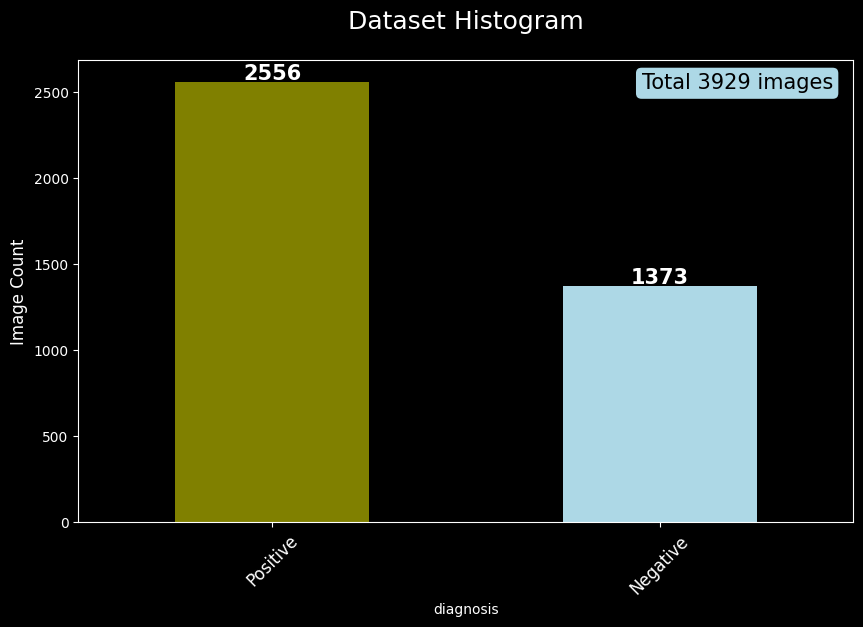

In [10]:
PlotUtils.plot_histogram(df)

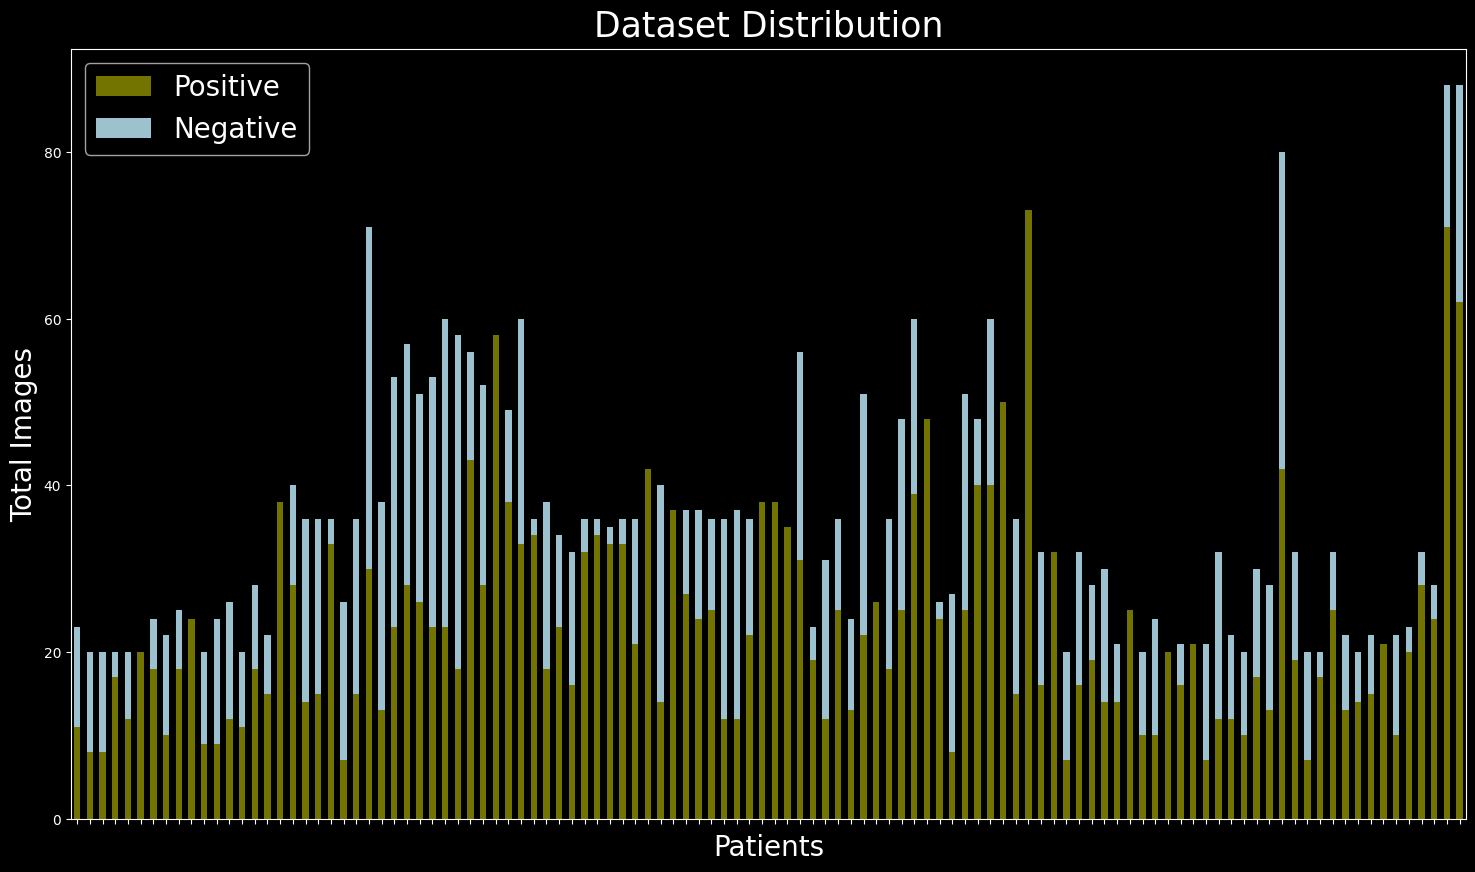

In [11]:
PlotUtils.plot_distribution(df)

In [12]:
sample_df = sample_pos_df.values
sample_imgs = []
for i, data in enumerate(sample_df):
    img = cv2.resize(cv2.imread(data[1]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[2]), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([img, mask])

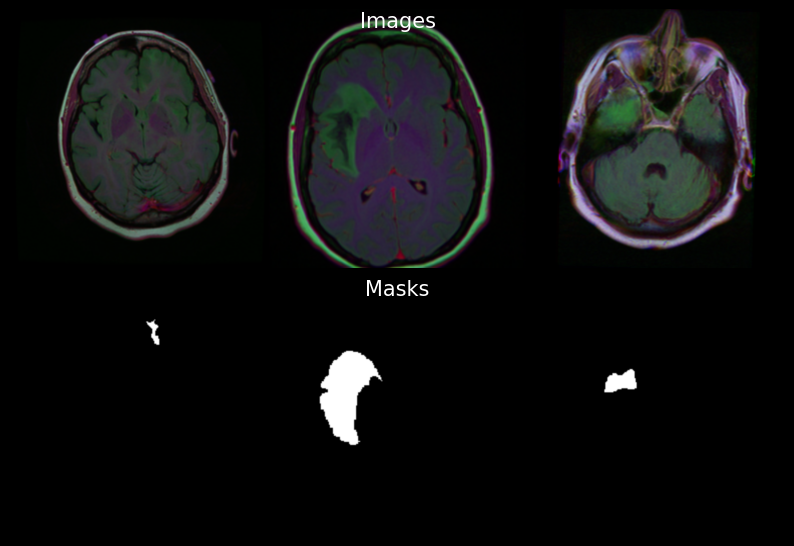

In [13]:
PlotUtils.general_plot(
    image_set=[np.array(sample_imgs[::2]), np.array(sample_imgs[1::2])], 
    titles=['Images', 'Masks'],
    cmaps = [None, None],
    nrows=2, ncols=1, y=0.9, hstack=True
)

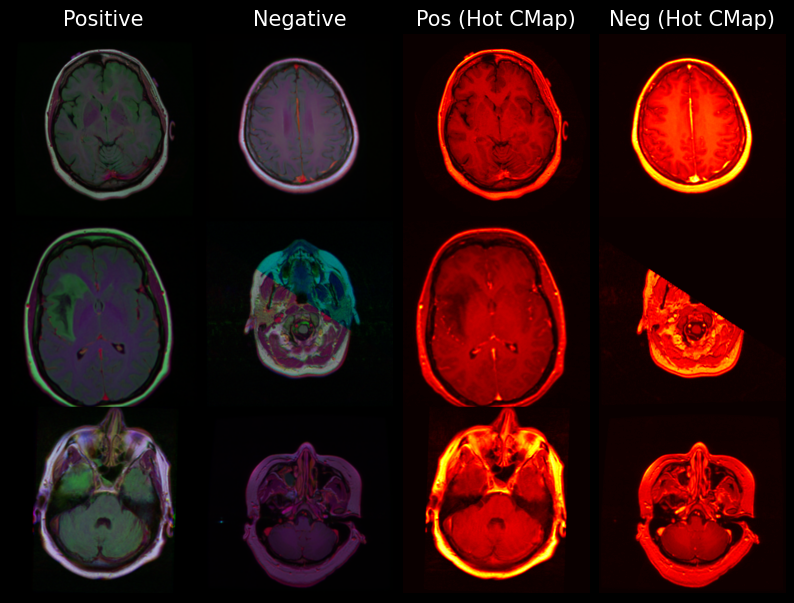

In [14]:
positive, negative = prepare_sample_images(sample_pos_df, sample_neg_df)
PlotUtils.general_plot(
    image_set=[positive, negative, positive[:, :, 0], negative[:, :, 0]],
    titles=['Positive', 'Negative', 'Pos (Hot CMap)', 'Neg (Hot CMap)'],
    cmaps=[None, None, 'hot', 'hot'],
    nrows=1, ncols=4, y=1
)

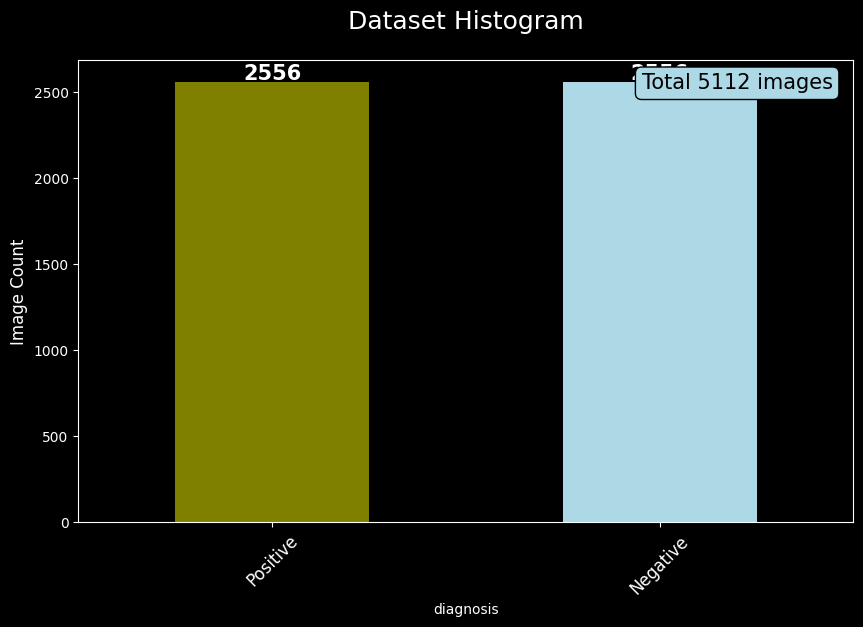

In [15]:
df = upsample_dataset(df)
PlotUtils.plot_histogram(df)

In [16]:
train_df, temp_df = split(df, test_size=0.2)
test_df, val_df = split(temp_df, test_size=0.5)

print_data_shapes(train_df, val_df, test_df)

Dataset    Shape          
-------------------------
Train      (4089, 4)
Validation (512, 4)
Test       (511, 4)


In [17]:
from torchvision.transforms.functional import resize
class AugmentPair:
    def __init__(self, rotation_range=15, scale_range=0.2, brightness_range=(0.9, 1.1)):
        self.rotation_range = rotation_range
        self.scale_range = scale_range
        self.brightness_range = brightness_range

    def rotate(self, input, angle):
        return rotate(input, angle)

    def scale(self, data, factor):
        width, height = data.size
        data = resize(data, (int(height * factor), int(width * factor)))
        return center_crop(data, (height, width))
    
    def adjust_brightness(self, input, factor):
        return adjust_brightness(input, factor)        
        
    def __call__(self, pair):
        image, mask = pair

        angle = np.random.uniform(-self.rotation_range, self.rotation_range)
        image = self.rotate(image, angle)
        mask = self.rotate(mask, angle)

        factor = np.random.uniform(1 - self.scale_range, 1 + self.scale_range)
        image = self.scale(image, factor)
        mask = self.scale(mask, factor)

        image = self.adjust_brightness(image, factor=np.random.uniform(*self.brightness_range))

        return image, mask

class MRIDataset(Dataset):
    def __init__(self, df, transformer=None):
        self.df = df
        self.transformer = transformer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Load image and mask with OpenCV
        image = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)  # 0 for grayscale

        # Convert to PIL Image
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        mask = Image.fromarray(mask)

        if self.transformer:
            image, mask = self.transformer((image, mask))

        # Convert to tensors
        image = to_tensor(image)
        mask = torch.tensor(np.array(mask) / 255.0, dtype=torch.float32).unsqueeze(0)

        return image, resize(mask, MASK_SIZE)


train_dataset = MRIDataset(train_df, transformer=AugmentPair())
train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=4, shuffle=True)

val_dataset = MRIDataset(val_df, transformer=None)
val_dataloader = DataLoader(val_dataset, batch_size=32, num_workers=4, shuffle=False)

test_dataset = MRIDataset(test_df, transformer=None)
test_dataloader = DataLoader(test_dataset, batch_size=32, num_workers=4, shuffle=False)

images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 128, 128])


In [18]:
combined_df = pd.concat([sample_pos_df, sample_neg_df], ignore_index=True)
shuffled_df = combined_df.sample(frac=1).reset_index(drop=True)
dataloader_ = DataLoader(MRIDataset(shuffled_df, transformer=AugmentPair()), 
                         batch_size=32, num_workers=4, shuffle=True)

images_, masks_ = next(iter(dataloader_))

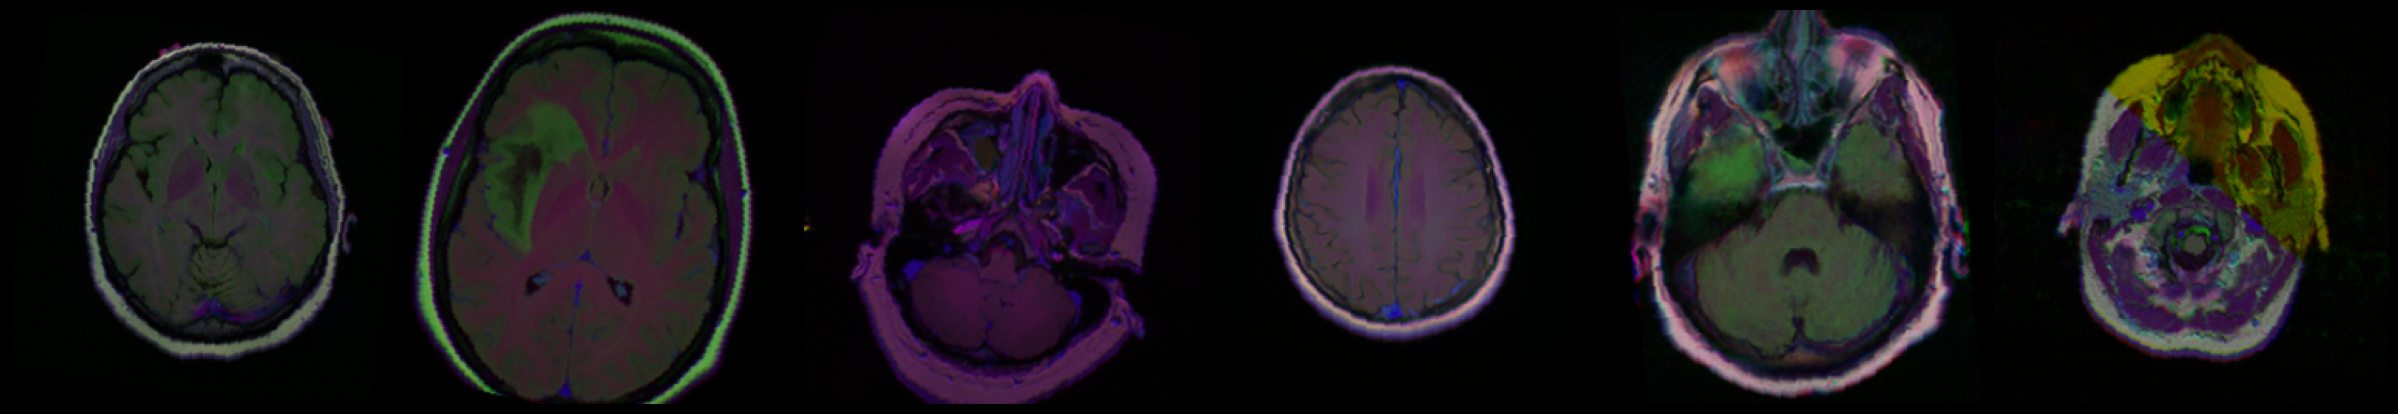

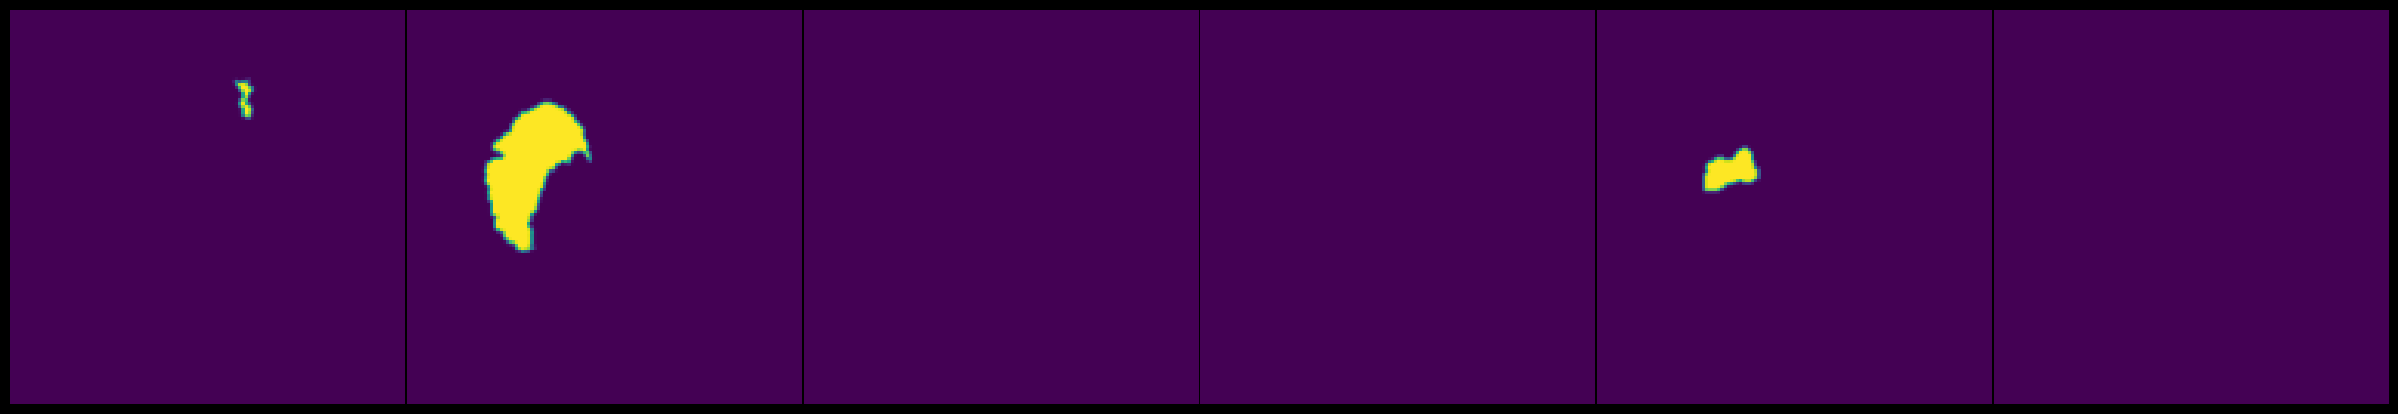

In [19]:
PlotUtils.plot_augmented_images(images_, mask=False)
PlotUtils.plot_augmented_images(masks_, mask=True)

In [20]:
class VGGEncoder(nn.Module):
    def __init__(self, pretrained=True):
        super(VGGEncoder, self).__init__()
        
        weights = VGG16_Weights.IMAGENET1K_V1 if pretrained else None
        vgg = models.vgg16(weights=weights)
        features = list(vgg.features.children())

        self.block1 = nn.Sequential(*features[:5])
        self.block2 = nn.Sequential(*features[5:10]) 
        self.block3 = nn.Sequential(*features[10:17])
        self.block4 = nn.Sequential(*features[17:24])
        self.block5 = nn.Sequential(*features[24:31])

    def forward(self, x):
        skip_connections = []
        
        x = self.block1(x)
        skip_connections.append(x)
        
        x = self.block2(x)
        skip_connections.append(x)
        
        x = self.block3(x)
        skip_connections.append(x)
        
        x = self.block4(x)
        skip_connections.append(x)
        
        x = self.block5(x)

        return x, skip_connections[::-1]  # Reverse for decoding
        
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()

        self.upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(out_channels + skip_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, skip):
        x = self.upsample(x) 
        x = torch.cat([x, skip], dim=1)
        x = self.relu(self.conv1(x)) 
        x = self.relu(self.conv2(x))
        return x

class UNetDecoder(nn.Module):
    def __init__(self, num_classes=1):
        super(UNetDecoder, self).__init__()
        self.decoder4 = DecoderBlock(512, 512, 256)  # Block 5 to Block 4
        self.decoder3 = DecoderBlock(256, 256, 128)  # Block 4 to Block 3
        self.decoder2 = DecoderBlock(128, 128, 64)   # Block 3 to Block 2
        self.decoder1 = DecoderBlock(64, 64, 32)     # Block 2 to Block 1

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x, skips):
        x = self.decoder4(x, skips[0])  # Skip from Block 4
        x = self.decoder3(x, skips[1])  # Skip from Block 3
        x = self.decoder2(x, skips[2])  # Skip from Block 2
        x = self.decoder1(x, skips[3])  # Skip from Block 1
        x = self.final_conv(x)          # Output layer
        return x

class UNet(nn.Module):
    def __init__(self, num_classes=1):
        super(UNet, self).__init__()
        self.encoder = VGGEncoder()
        self.decoder = UNetDecoder()

    def forward(self, x):
        # Encoder forward pass
        x, skips = self.encoder(x)  
        # Decoder forward pass
        x = self.decoder(x, skips)  
        return x

In [21]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss, total_dice, total_iou, total_accuracy = 0, 0, 0, 0

    for images, masks in tqdm(dataloader, desc="Training", leave=False):    
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = dice_loss(outputs, masks) + criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_dice += dice_coefficient(outputs, masks).item()
        total_iou += iou_score(outputs, masks).item()

        correct = (outputs == masks).float().sum()  # Correct pixels
        total_pixels = torch.numel(masks)           # Total pixels
        accuracy = correct / total_pixels
        total_accuracy += accuracy.item()
    
    return (total_loss / len(dataloader)), (total_dice / len(dataloader)), (total_iou / len(dataloader)), total_accuracy

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss, total_dice, total_iou, total_accuracy = 0, 0, 0, 0

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Validating", leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = dice_loss(outputs, masks) + criterion(outputs, masks)

            total_loss += loss.item()
            total_dice += dice_coefficient(outputs, masks).item()
            total_iou += iou_score(outputs, masks).item()
            
            correct = (outputs == masks).float().sum()  # Correct pixels
            total_pixels = torch.numel(masks)           # Total pixels
            accuracy = correct / total_pixels
            total_accuracy += accuracy.item()
    
    return total_loss / len(dataloader), total_dice / len(dataloader), total_iou / len(dataloader), total_accuracy


In [45]:
from torchvision.transforms.functional import resize
def test_model(model, dataloader, device):
    model.eval()
    total_dice, total_iou = 0, 0
    samples = []

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            total_dice += dice_coefficient(outputs, masks).item()
            total_iou += iou_score(outputs, masks).item()

            # Store sample predictions for visualization
            samples.append((images.cpu(), masks.cpu(), outputs.cpu()))

    avg_dice = total_dice / len(dataloader)
    avg_iou = total_iou / len(dataloader)
    
    return avg_dice, avg_iou, samples

In [23]:
model = UNet()
print(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=3e-4)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 234MB/s] 


UNet(
  (encoder): VGGEncoder(
    (block1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 

In [24]:
best_val_loss = np.inf  
early_stop_counter = 0

train_accs, val_accs = [], []
train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dice_scores, val_dice_scores = [], []

for epoch in range(EPOCHS):
    train_loss, train_dice, train_iou, train_acc = train_one_epoch(model, train_dataloader, criterion, optimizer, device)
    val_loss, val_dice, val_iou, val_acc = validate_one_epoch(model, val_dataloader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_dice_scores.append(train_dice)
    val_dice_scores.append(val_dice)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_ious.append(train_iou)
    val_ious.append(val_iou)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, Train IoU: {train_iou:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}, Val IoU: {val_iou:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

print("Training complete.")

Epoch 1/150
Train Loss: 1.0082, Train Dice: 0.0780, Train IoU: 0.0523
Val Loss: 0.5603, Val Dice: 0.4717, Val IoU: 0.3133


Epoch 2/150
Train Loss: 0.4572, Train Dice: 0.5719, Train IoU: 0.4125
Val Loss: 0.4201, Val Dice: 0.6055, Val IoU: 0.4393


Epoch 3/150
Train Loss: 0.3275, Train Dice: 0.6927, Train IoU: 0.5386
Val Loss: 0.2399, Val Dice: 0.7766, Val IoU: 0.6379


Epoch 4/150
Train Loss: 0.2487, Train Dice: 0.7669, Train IoU: 0.6267
Val Loss: 0.2440, Val Dice: 0.7697, Val IoU: 0.6284


Epoch 5/150
Train Loss: 0.2079, Train Dice: 0.8050, Train IoU: 0.6779
Val Loss: 0.1732, Val Dice: 0.8372, Val IoU: 0.7207


Epoch 6/150
Train Loss: 0.1600, Train Dice: 0.8502, Train IoU: 0.7408
Val Loss: 0.1934, Val Dice: 0.8178, Val IoU: 0.6927


Epoch 7/150
Train Loss: 0.1520, Train Dice: 0.8574, Train IoU: 0.7519
Val Loss: 0.1626, Val Dice: 0.8475, Val IoU: 0.7368


Epoch 8/150
Train Loss: 0.1561, Train Dice: 0.8533, Train IoU: 0.7466
Val Loss: 0.1357, Val Dice: 0.8727, Val IoU: 0.7748


Epoch 9/150
Train Loss: 0.1393, Train Dice: 0.8692, Train IoU: 0.7696
Val Loss: 0.1236, Val Dice: 0.8841, Val IoU: 0.7928


Epoch 10/150
Train Loss: 0.1206, Train Dice: 0.8866, Train IoU: 0.7970
Val Loss: 0.1116, Val Dice: 0.8956, Val IoU: 0.8117


Epoch 11/150
Train Loss: 0.1168, Train Dice: 0.8901, Train IoU: 0.8026
Val Loss: 0.1047, Val Dice: 0.9021, Val IoU: 0.8222


Epoch 12/150
Train Loss: 0.1146, Train Dice: 0.8922, Train IoU: 0.8060
Val Loss: 0.1208, Val Dice: 0.8865, Val IoU: 0.7968


Epoch 13/150
Train Loss: 0.1112, Train Dice: 0.8954, Train IoU: 0.8113
Val Loss: 0.1065, Val Dice: 0.9005, Val IoU: 0.8196


Epoch 14/150
Train Loss: 0.1073, Train Dice: 0.8991, Train IoU: 0.8173
Val Loss: 0.1036, Val Dice: 0.9030, Val IoU: 0.8237


Epoch 15/150
Train Loss: 0.1080, Train Dice: 0.8983, Train IoU: 0.8162
Val Loss: 0.1006, Val Dice: 0.9060, Val IoU: 0.8286


Epoch 16/150
Train Loss: 0.1038, Train Dice: 0.9022, Train IoU: 0.8226
Val Loss: 0.0963, Val Dice: 0.9099, Val IoU: 0.8352


Epoch 17/150
Train Loss: 0.0990, Train Dice: 0.9068, Train IoU: 0.8299
Val Loss: 0.0980, Val Dice: 0.9081, Val IoU: 0.8321


Epoch 18/150
Train Loss: 0.0963, Train Dice: 0.9093, Train IoU: 0.8340
Val Loss: 0.1000, Val Dice: 0.9064, Val IoU: 0.8292


Epoch 19/150
Train Loss: 0.1516, Train Dice: 0.8577, Train IoU: 0.7545
Val Loss: 0.1282, Val Dice: 0.8797, Val IoU: 0.7857


Epoch 20/150
Train Loss: 0.1320, Train Dice: 0.8761, Train IoU: 0.7815
Val Loss: 0.1055, Val Dice: 0.9013, Val IoU: 0.8208


Epoch 21/150
Train Loss: 0.1015, Train Dice: 0.9044, Train IoU: 0.8260
Val Loss: 0.0944, Val Dice: 0.9119, Val IoU: 0.8386


Epoch 22/150
Train Loss: 0.0988, Train Dice: 0.9069, Train IoU: 0.8303
Val Loss: 0.0935, Val Dice: 0.9124, Val IoU: 0.8394


Epoch 23/150
Train Loss: 0.0926, Train Dice: 0.9128, Train IoU: 0.8400
Val Loss: 0.0954, Val Dice: 0.9109, Val IoU: 0.8369


Epoch 24/150
Train Loss: 0.0911, Train Dice: 0.9142, Train IoU: 0.8422
Val Loss: 0.0950, Val Dice: 0.9111, Val IoU: 0.8372


Epoch 25/150
Train Loss: 0.0883, Train Dice: 0.9168, Train IoU: 0.8467
Val Loss: 0.0930, Val Dice: 0.9129, Val IoU: 0.8402


Epoch 26/150
Train Loss: 0.0880, Train Dice: 0.9170, Train IoU: 0.8470
Val Loss: 0.0871, Val Dice: 0.9188, Val IoU: 0.8503


Epoch 27/150
Train Loss: 0.0862, Train Dice: 0.9188, Train IoU: 0.8500
Val Loss: 0.0867, Val Dice: 0.9189, Val IoU: 0.8504


Epoch 28/150
Train Loss: 0.0840, Train Dice: 0.9209, Train IoU: 0.8536
Val Loss: 0.0875, Val Dice: 0.9182, Val IoU: 0.8491


Epoch 29/150
Train Loss: 0.0865, Train Dice: 0.9185, Train IoU: 0.8495
Val Loss: 0.0893, Val Dice: 0.9164, Val IoU: 0.8461


Epoch 30/150
Train Loss: 0.1017, Train Dice: 0.9043, Train IoU: 0.8261
Val Loss: 0.0932, Val Dice: 0.9126, Val IoU: 0.8397


Epoch 31/150
Train Loss: 0.0897, Train Dice: 0.9154, Train IoU: 0.8444
Val Loss: 0.0850, Val Dice: 0.9207, Val IoU: 0.8535


Epoch 32/150
Train Loss: 0.0854, Train Dice: 0.9195, Train IoU: 0.8513
Val Loss: 0.0914, Val Dice: 0.9142, Val IoU: 0.8424


Epoch 33/150
Train Loss: 0.0830, Train Dice: 0.9218, Train IoU: 0.8551
Val Loss: 0.0909, Val Dice: 0.9152, Val IoU: 0.8443


Epoch 34/150
Train Loss: 0.0912, Train Dice: 0.9141, Train IoU: 0.8423
Val Loss: 0.0831, Val Dice: 0.9224, Val IoU: 0.8565


Epoch 35/150
Train Loss: 0.0820, Train Dice: 0.9227, Train IoU: 0.8567
Val Loss: 0.0886, Val Dice: 0.9169, Val IoU: 0.8469


Epoch 36/150
Train Loss: 0.0802, Train Dice: 0.9244, Train IoU: 0.8597
Val Loss: 0.0850, Val Dice: 0.9205, Val IoU: 0.8531


Epoch 37/150
Train Loss: 0.0815, Train Dice: 0.9232, Train IoU: 0.8576
Val Loss: 0.0846, Val Dice: 0.9212, Val IoU: 0.8543


Epoch 38/150
Train Loss: 0.0820, Train Dice: 0.9228, Train IoU: 0.8569
Val Loss: 0.0832, Val Dice: 0.9223, Val IoU: 0.8561


Epoch 39/150
Train Loss: 0.0895, Train Dice: 0.9159, Train IoU: 0.8458
Val Loss: 0.2287, Val Dice: 0.7841, Val IoU: 0.6496
Early stopping triggered at epoch 39
Training complete.


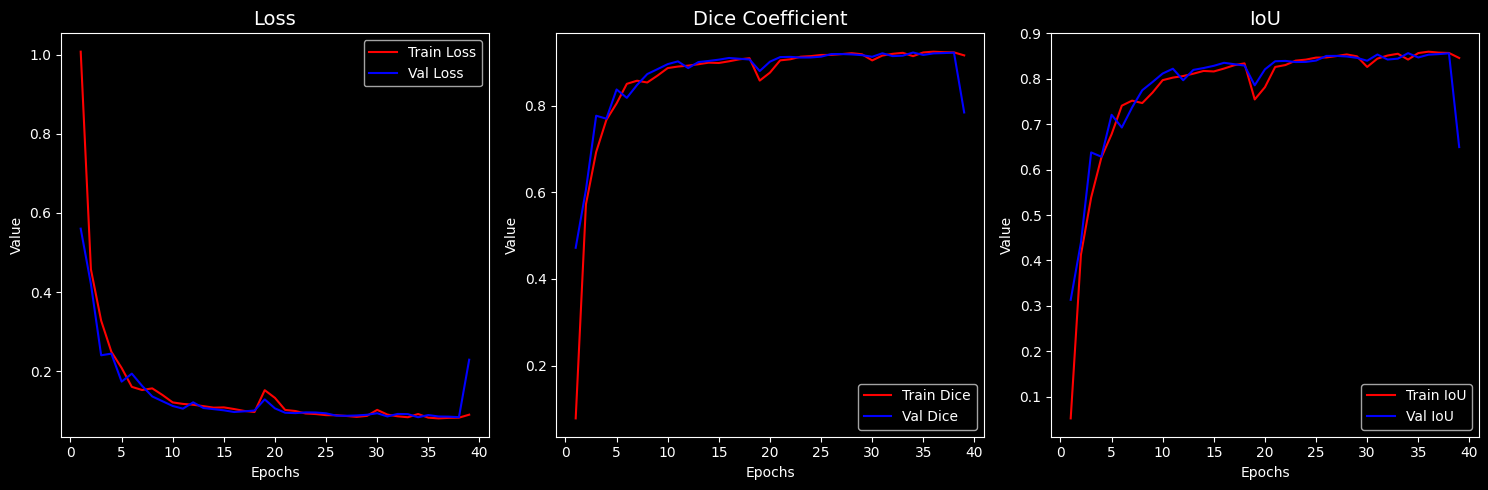

In [38]:
train_metrics = [train_losses, train_dice_scores, train_ious]
val_metrics = [val_losses, val_dice_scores, val_ious]
titles=['Loss', 'Dice Coefficient', 'IoU'] 
labels=[['Train Loss', 'Val Loss'], ['Train Dice', 'Val Dice'], ['Train IoU', 'Val IoU']]

PlotUtils.plot_metrics(train_metrics, val_metrics, titles, labels)

In [42]:
state_dict = torch.load("best_model.pth", map_location=device)
model.load_state_dict(state_dict)
model.to(device) 

/tmp/ipykernel_23/4243289501.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("best_model.pth", map_location=device)


UNet(
  (encoder): VGGEncoder(
    (block1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 

In [46]:
avg_dice, avg_iou, samples = test_model(model, test_dataloader, device)
print(f"Test Avg Dice Score: {avg_dice:.4f}, Test Avg IoU Score: {avg_iou:.4f}")

Test Avg Dice Score: 0.9158, Test Avg IoU Score: 0.8449


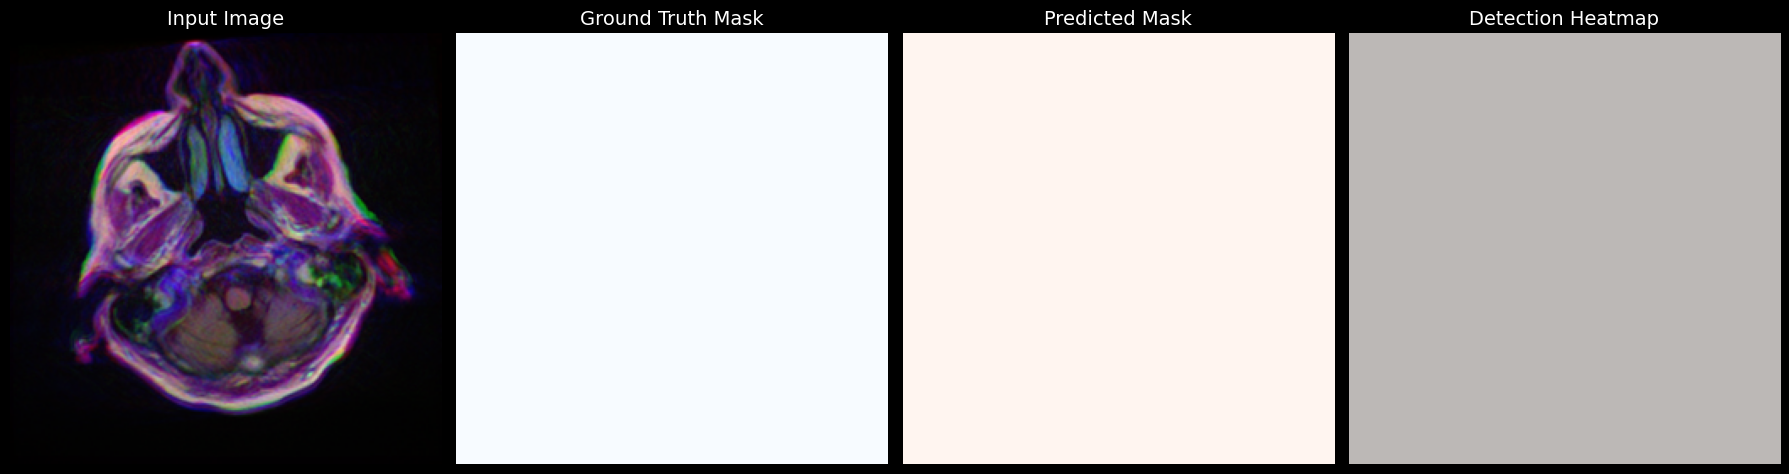

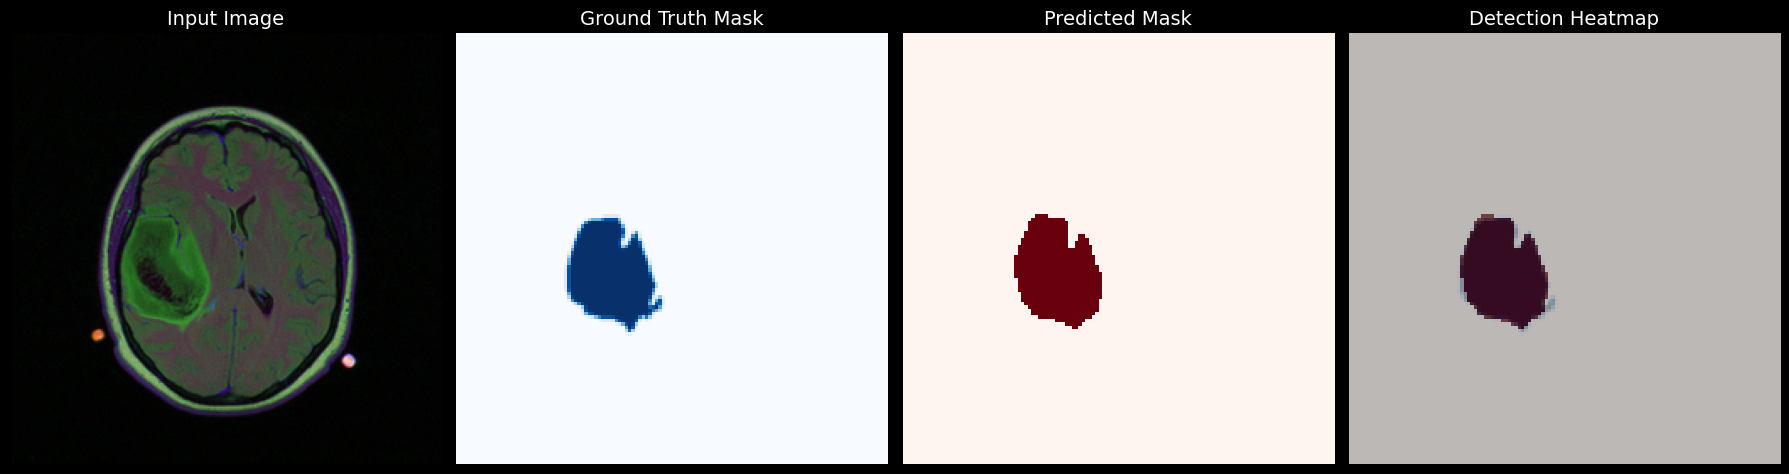

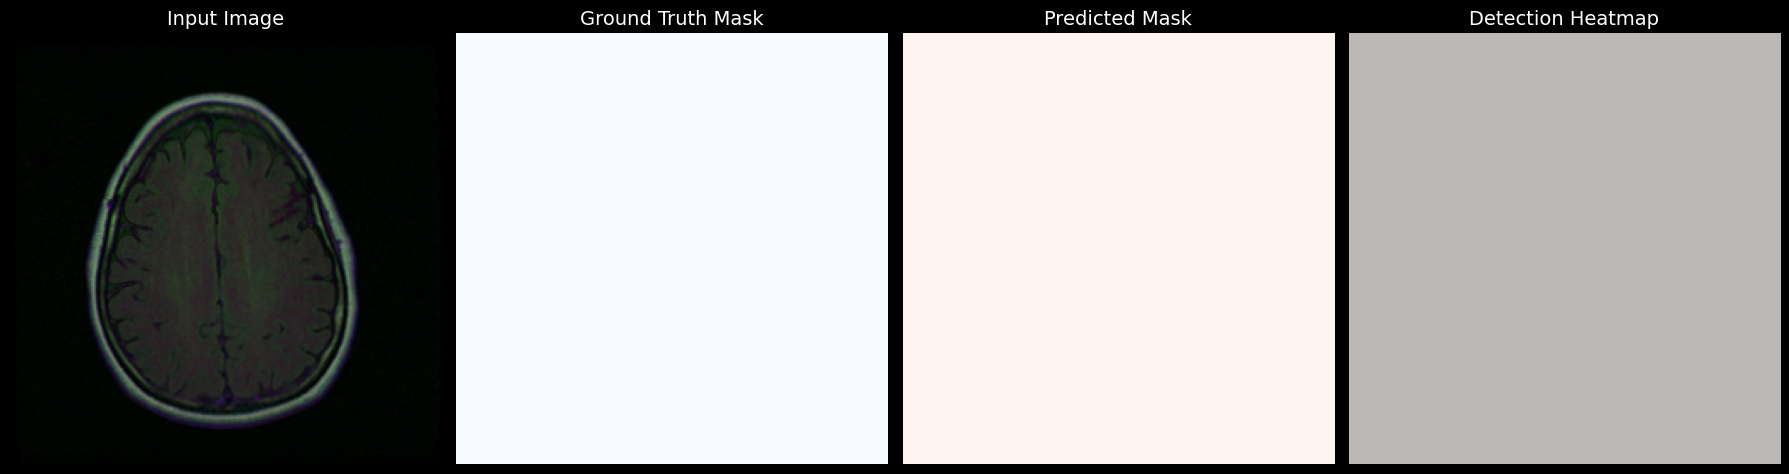

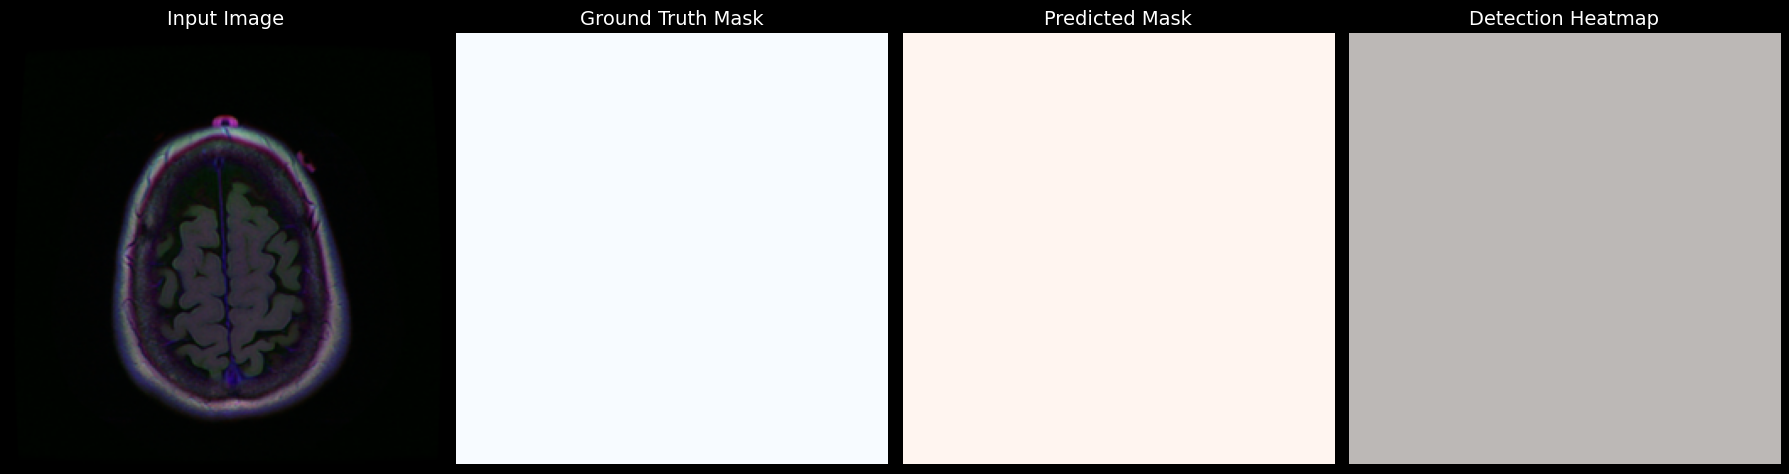

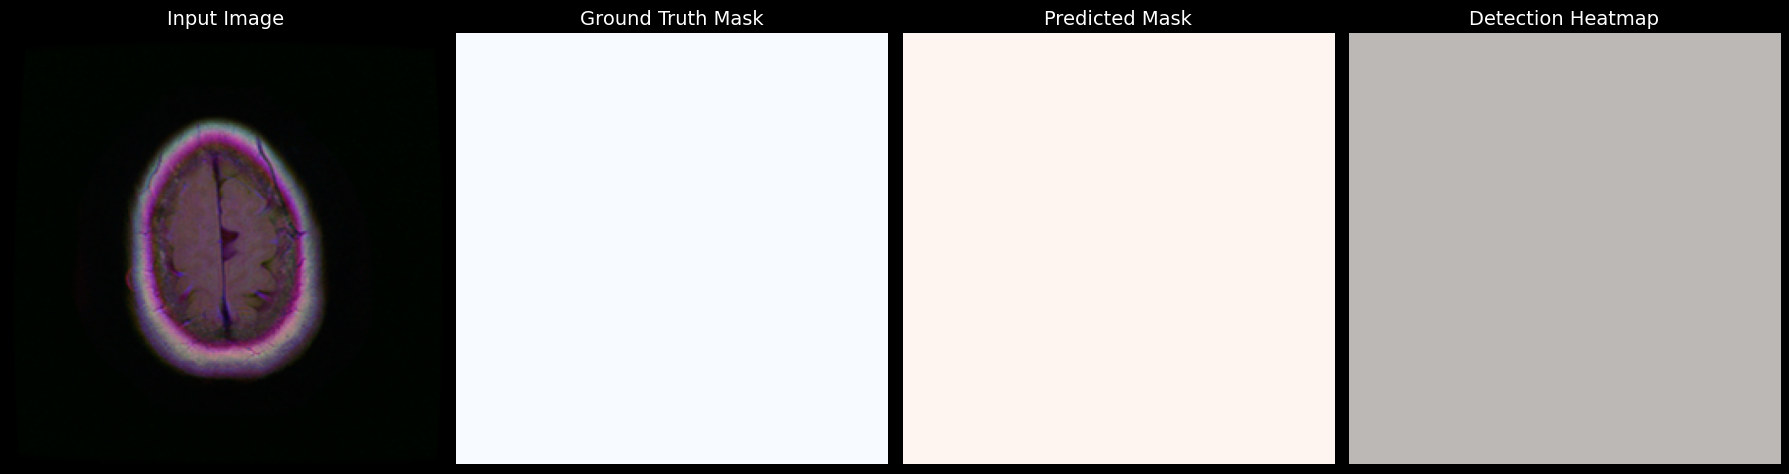

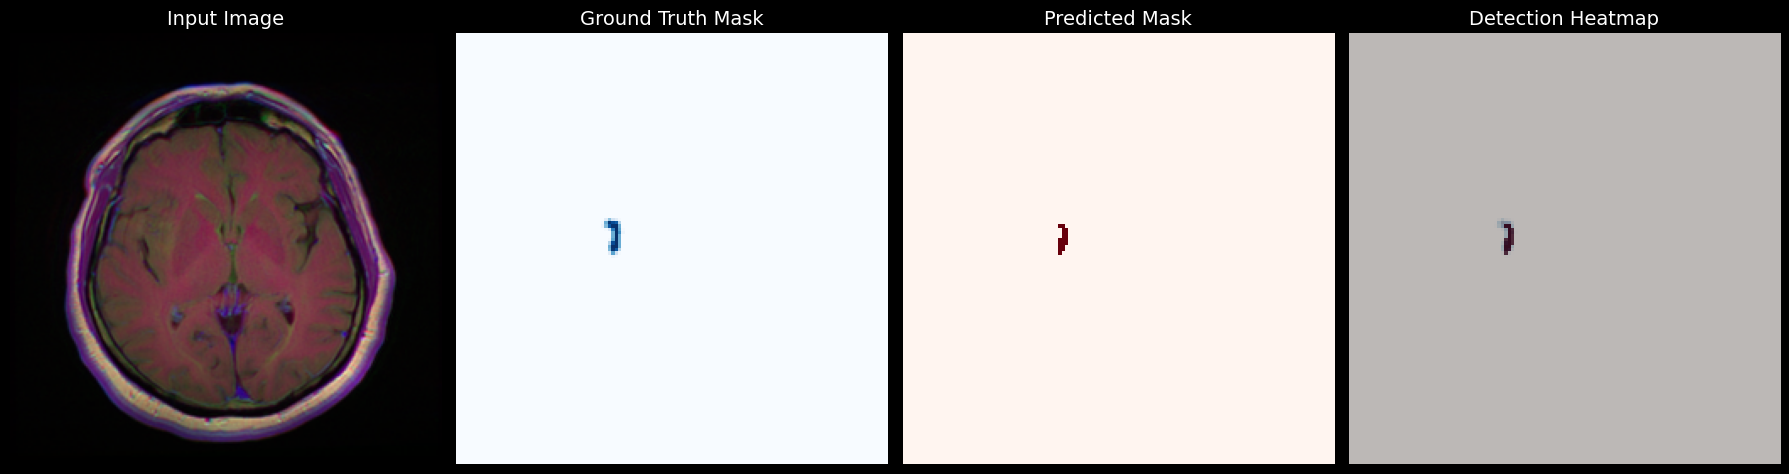

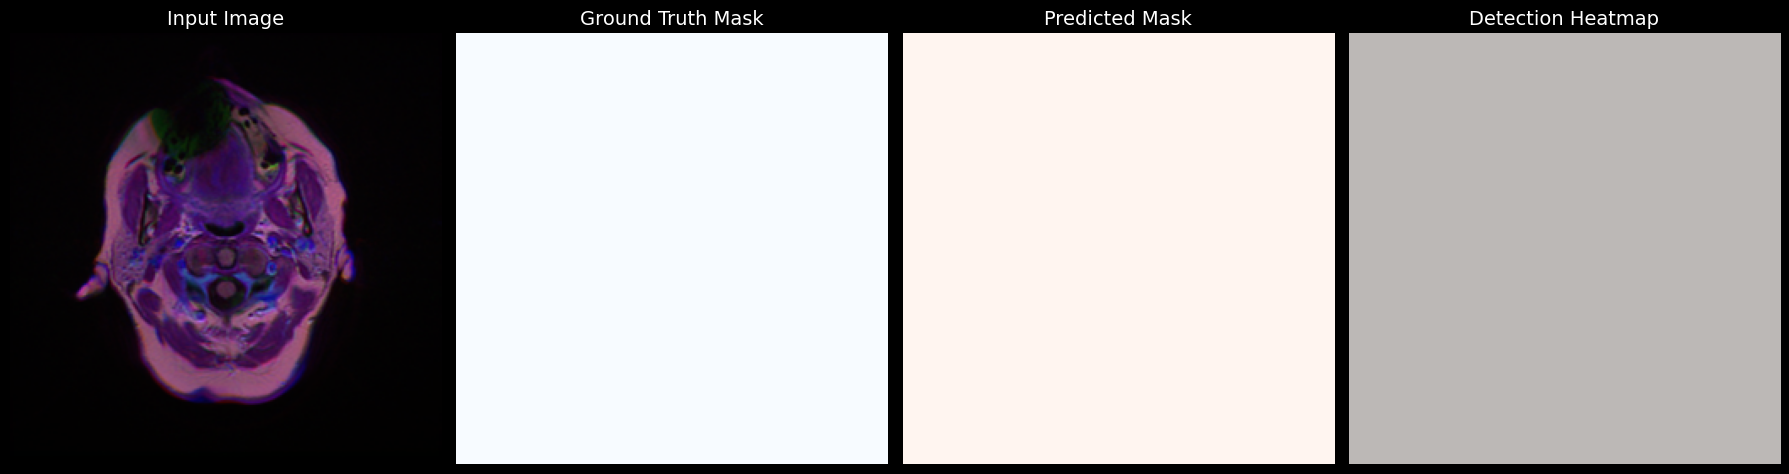

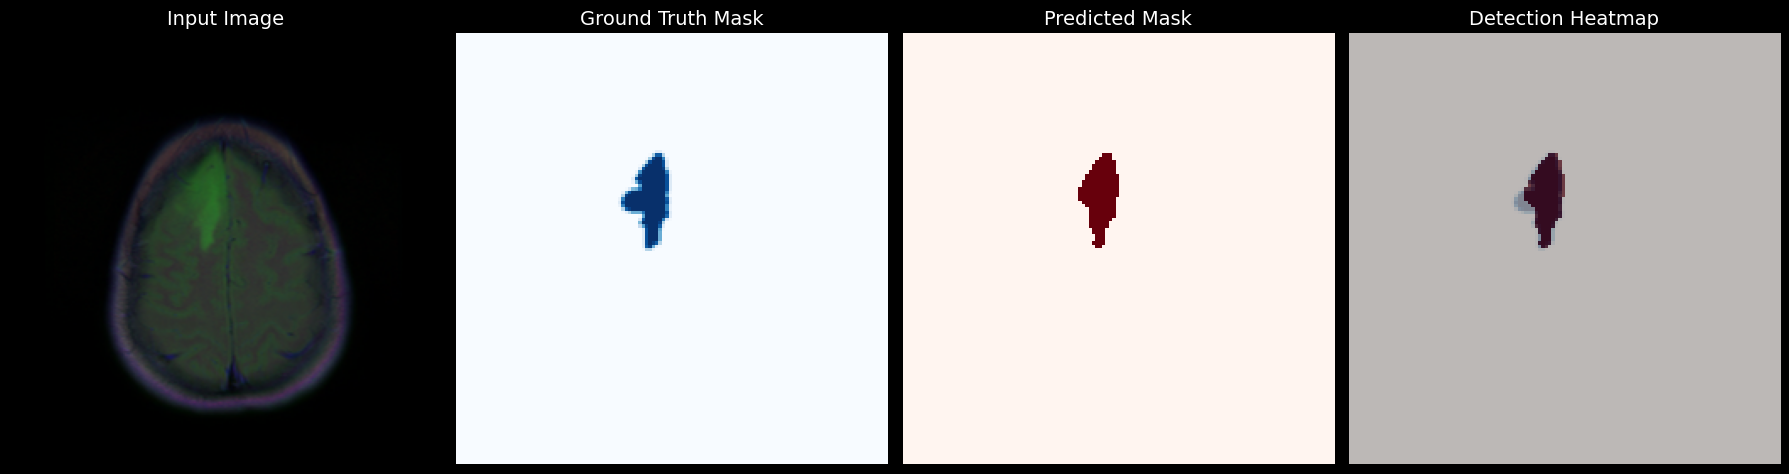

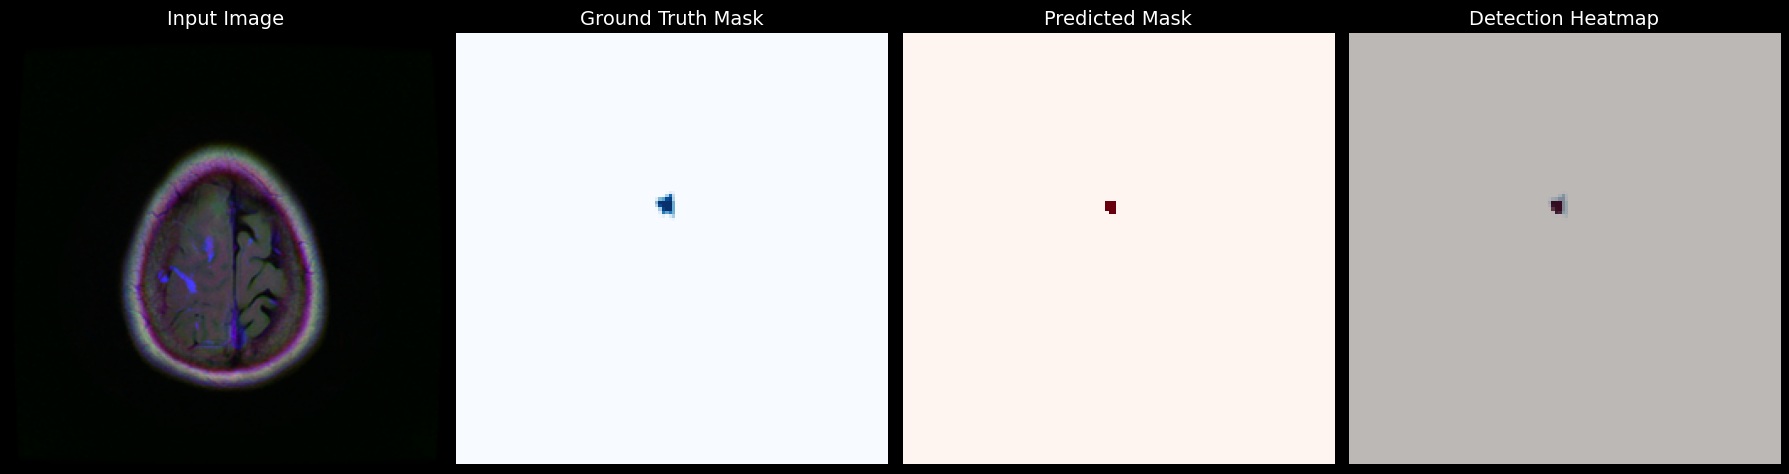

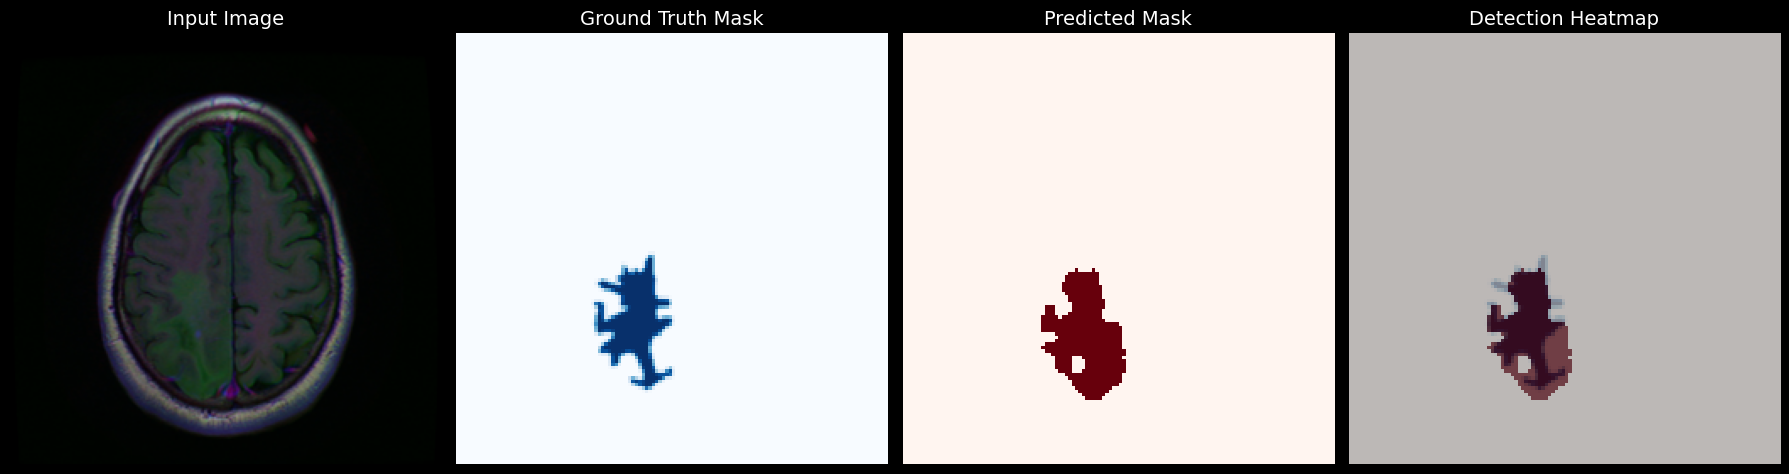

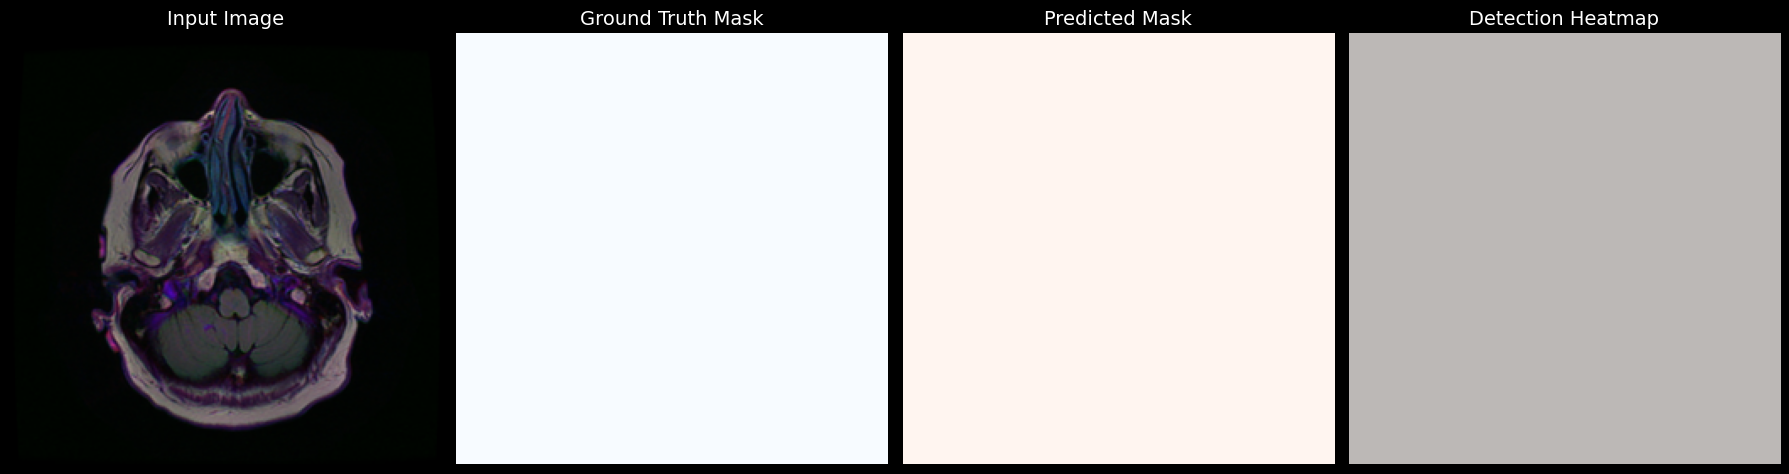

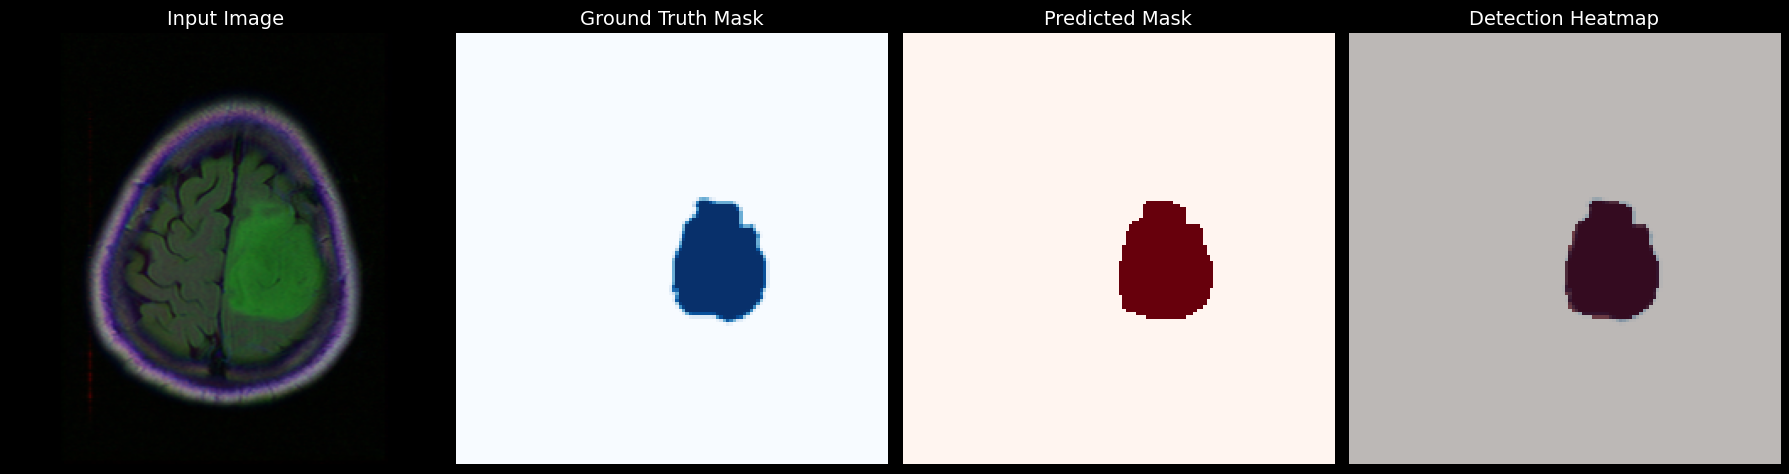

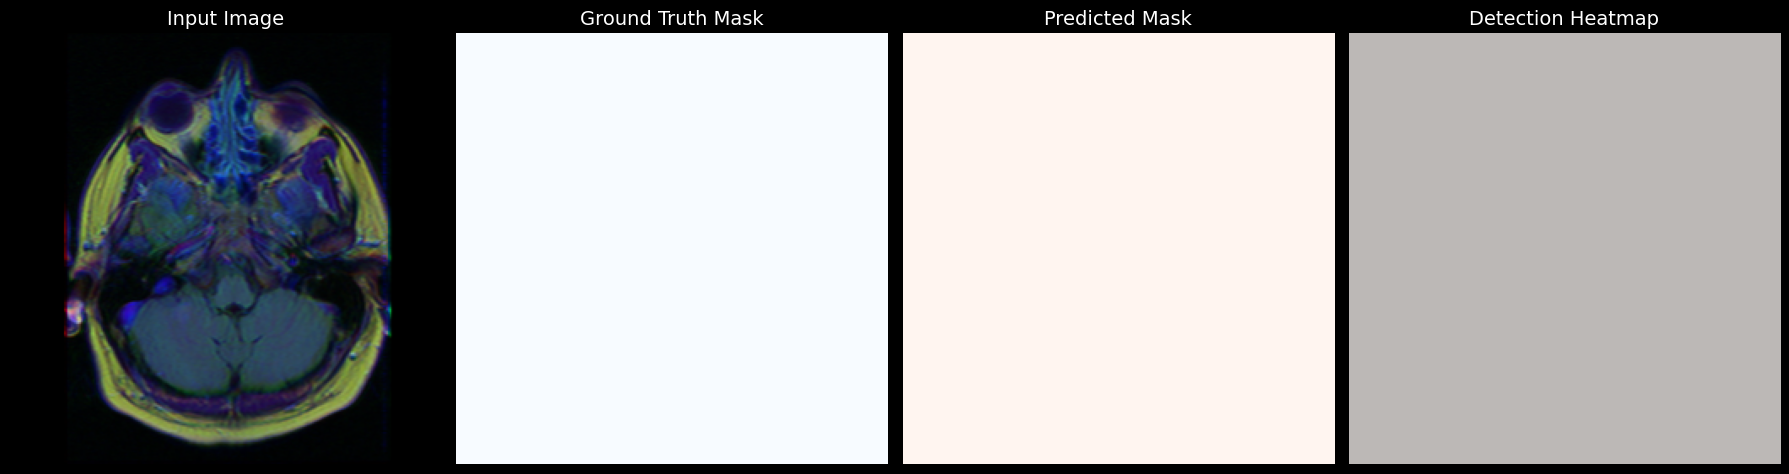

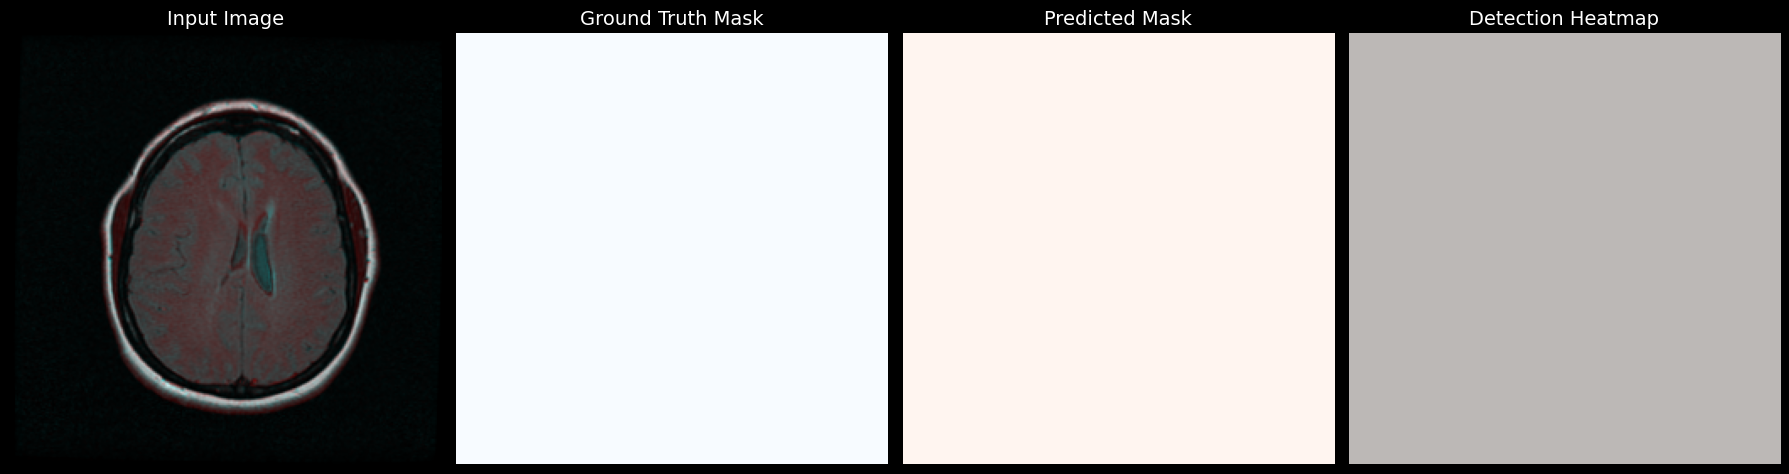

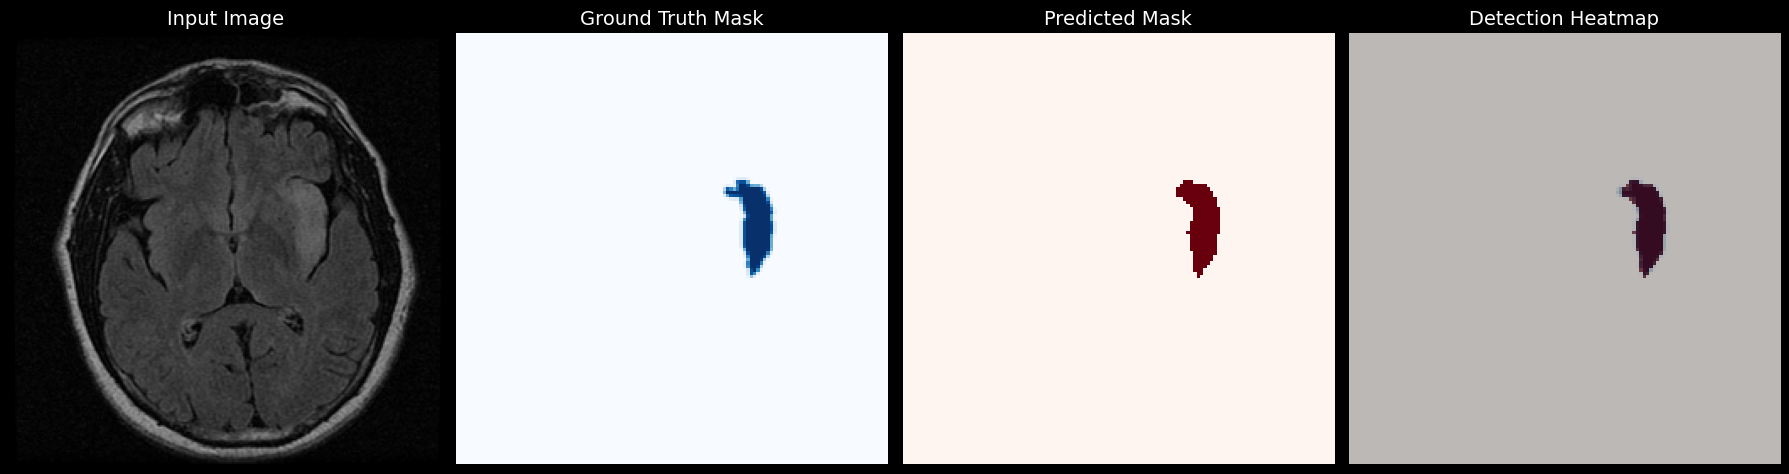

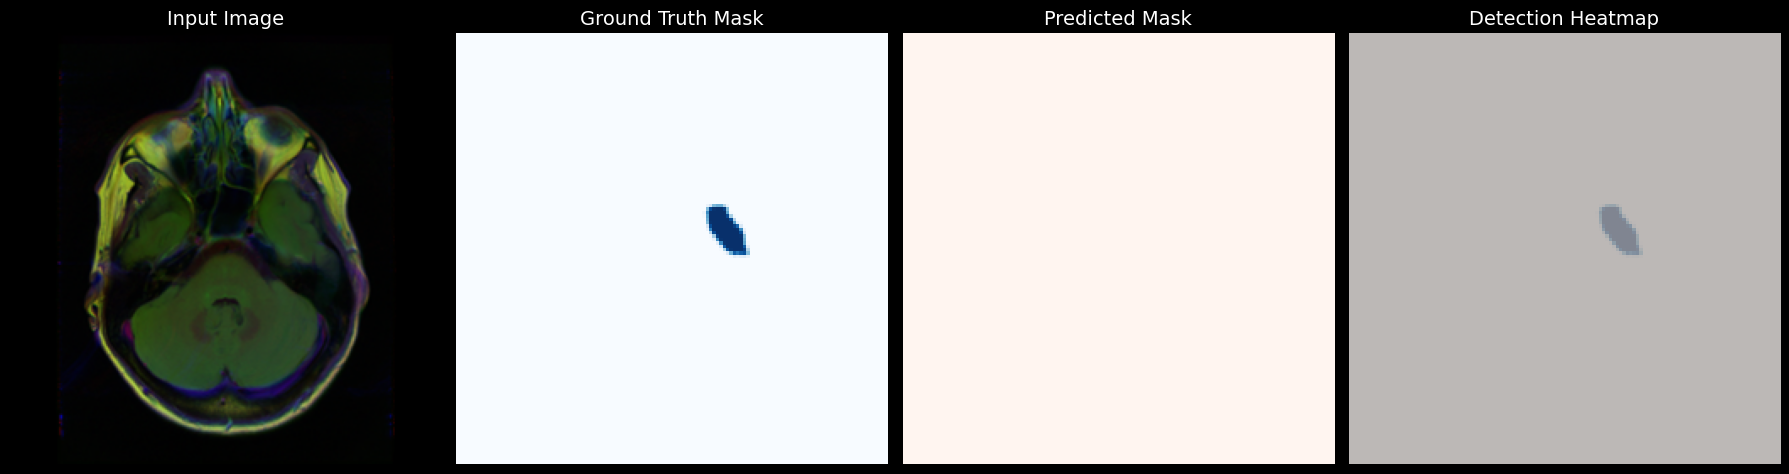

In [47]:
PlotUtils.plot_samples(samples, num_samples=16)